In [21]:
# !pip install openpyxl

     |████████████████████████████████| 243 kB 1.5 MB/s eta 0:00:01
ERROR: Error while checking for conflicts. Please file an issue on pip's issue tracker: https://github.com/pypa/pip/issues/new
Traceback (most recent call last):
  File "/Users/gabe/miniconda3/lib/python3.8/site-packages/pip/_vendor/pkg_resources/__init__.py", line 3021, in _dep_map
    return self.__dep_map
  File "/Users/gabe/miniconda3/lib/python3.8/site-packages/pip/_vendor/pkg_resources/__init__.py", line 2815, in __getattr__
    raise AttributeError(attr)
AttributeError: _DistInfoDistribution__dep_map

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/gabe/miniconda3/lib/python3.8/site-packages/pip/_vendor/pkg_resources/__init__.py", line 3012, in _parsed_pkg_info
    return self._pkg_info
  File "/Users/gabe/miniconda3/lib/python3.8/site-packages/pip/_vendor/pkg_resources/__init__.py", line 2815, in __getattr__
    raise AttributeError(attr)
At

In [160]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import os
pd.options.display.max_columns = 1000

In [161]:
gdf = gpd.read_file("shapes/MD_precinct_primaries/")
cols = ["geometry", "NAME"] + list(filter(lambda x: "VAP" in x, gdf.columns)) + list(filter(lambda x: "18" in x, gdf.columns))
# gdf = gdf[cols]
gdf["COUNTY"] = gdf["NAME"].apply(lambda x: x.split(" Precinct ")[0])
gdf["PRECINCT"] = gdf["NAME"].apply(lambda x: x.split(" Precinct ")[-1])
gdf["MATCH"] = gdf["COUNTY"] + " " + gdf["PRECINCT"]
gdf = gdf.set_index("MATCH")

In [162]:
turnout = pd.read_excel("tabular/GG18 Voter TurnOut By Precinct By Party Revised.xlsx", header=4)
turnout = turnout[turnout["District"] != "---"]
turnout = turnout[cols]
turnout["MATCH"] = turnout["County"] + " " + turnout["District"].apply(lambda x: x[1:]) + "-" + turnout["Precinct"]
turnout = turnout.set_index("MATCH")

In [163]:
counties = set(gdf["COUNTY"])
gdf["Dem_turnout_weight"] = 0
gdf["Rep_turnout_weight"] = 0
gdf["VAP_turnout_weight"] = 0
for county in counties:
    tmp = gdf[gdf["COUNTY"] == county]
    TOT_VAP = tmp["ADJ_VAP"].sum()
    idxs = set(tmp.index)   
    for party in ["Dem", "Rep"]:
        try:
            TOT_VOTES = sum([turnout[f"Total Voted {party}"].loc[idx.replace("St.", "Saint")] for idx in idxs])
            for idx in idxs:
                votes = turnout[f"Total Voted {party}"].loc[idx.replace("St.", "Saint")]
                gdf[f"{party}_turnout_weight"].loc[idx] = votes / TOT_VOTES
                gdf["VAP_turnout_weight"].loc[idx] = gdf["ADJ_VAP"].loc[idx] / TOT_VAP
        except:
            print(f"*** Something is wrong with {county}")
            gdf_precs = idxs
            turnout_precs = set(filter(lambda x: county in x, turnout.index))
    #         print(f"gdf_precs len = {len(gdf_precs)}")
    #         print(f"turnout_precs len = {len(turnout_precs)}")
    #         print(f"gdf - turnout = {gdf_precs.difference(turnout_precs)}")
    #         print(f"turnout - gdf = {turnout_precs.difference(gdf_precs)}")
    #     break

/Users/gabe/miniconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


*** Something is wrong with Prince George's
*** Something is wrong with Prince George's
*** Something is wrong with Frederick
*** Something is wrong with Frederick


In [164]:
extra_votes = pd.read_csv("tabular/MD_abs_primary.csv", index_col=0)

In [165]:
gdf["GOV18D_adj_vote"] = 0
gdf["GOV18D_adj_vap"] = 0
gdf["GOV18R_adj_vote"] = 0
gdf["GOV18R_adj_vap"] = 0
for i in range(len(gdf)):
    county = gdf["COUNTY"].iloc[i].replace("'", "’")
    gdf["GOV18D_adj_vote"].iloc[i] = gdf["GOV18D"].iloc[i] + (gdf["Dem_turnout_weight"].iloc[i] * extra_votes["GOV18_BJEALOUS"].loc[county])
    gdf["GOV18D_adj_vap"].iloc[i] = gdf["GOV18D"].iloc[i] + (gdf["VAP_turnout_weight"].iloc[i] * extra_votes["GOV18_BJEALOUS"].loc[county])
    gdf["GOV18R_adj_vote"].iloc[i] = gdf["GOV18R"].iloc[i] + (gdf["Rep_turnout_weight"].iloc[i] * extra_votes["GOV18_BJEALOUS"].loc[county])
    gdf["GOV18R_adj_vap"].iloc[i] = gdf["GOV18R"].iloc[i] + (gdf["VAP_turnout_weight"].iloc[i] * extra_votes["GOV18_BJEALOUS"].loc[county])

In [166]:
def plot_choro(gdf, column, cmap='YlOrBr', county=None, save=False):
    if county is not None:
        gdf = gdf[gdf["COUNTY"] == county]
    fig, ax = plt.subplots(figsize=(12,8))
    plt.title(f"{column}")
    gdf.plot(ax=ax,
             column=column,
             cmap=cmap,
            )
    plt.axis('off')
    os.makedirs("plots", exist_ok=True)
    plt.savefig(f"plots/MD_{county if county is not None else ''}_{column}.png", dpi=500, bbox_inches='tight')
    plt.show()

In [168]:
vote_cols = ["GOV18D_adj_vote", "GOV18D_adj_vap", "GOV18D"]
for col in vote_cols:
    gdf[f"{col}_pct"] = 0
for i in range(len(gdf)):
    county = gdf["COUNTY"].iloc[i]
    for col in vote_cols:
        gdf[f"{col}_pct"].iloc[i] = gdf[col].iloc[i] / gdf.groupby("COUNTY").sum()[col].loc[county]

In [170]:
gdf

,NAME,CNG02,COUNTY,LEG02,VTD,MCD,STATE,VTD_1,PLACE,UNADJPOP,ADJ_POP,ADJ_WHITE,ADJ_BLACK,ADJ_AMIN,ADJ_ASIAN,ADJ_NHPI,ADJ_OTHER,ADJ_VAP,ADJ_2MORE,UNADJHISP,ADJ_WVAP,ADJ_BVAP,ADJAMINVAP,ADJASNVAP,ADJNHPIVAP,ADJOTHVAP,OCCUPIED,UNOCCUPIED,PRES12R,PRES12D,SEN12R,SEN12D,SEN12U,SEN12L,USH12R,USH12D,GOV14R,GOV14D,AG14D,AG14R,AG14L,COMP14R,COMP14D,USH14R,USH14D,SSEN14R,SSEN14D,SSEN14U,PRES16R,PRES16D,PRES16L,PRES16G,SEN16R,SEN16D,SEN16G,USH16R,USH16D,GOV18R,GOV18D,SEN18R,SEN18D,USH18R,USH18D,AG18R,AG18D,COMP18R,COMP18D,SSEN18R,SSEN18D,SSEN18G,SSEN18L,SSEN18U,TOTPOP,NH_WHITE,NH_BLACK,NH_AMIN,NH_ASIAN,NH_NHPI,NH_OTHER,NH_2MORE,HISP,H_WHITE,H_BLACK,H_AMIN,H_ASIAN,H_NHPI,H_OTHER,H_2MORE,VAP,HVAP,WVAP,BVAP,AMINVAP,ASIANVAP,NHPIVAP,OTHERVAP,2MOREVAP,CD,HDIST,SEND,SEN12PD_BC,SEN12PD_CM,SEN12PD_TO,AG14PD_ABR,AG14PD_BFR,AG14PD_JCA,AG14PD_TOT,GOV14PD_AB,GOV14PD_DG,GOV14PD_HM,GOV14PD_TO,SEN16PD_CV,SEN16PD_DE,SEN16PD_TO,GOV18PD_BJ,GOV18PD_JS,GOV18PD_KV,GOV18PD_RM,GOV18PD_RB,GOV18PD_TO,geometry,PRECINCT,Dem_turnout_weight,Rep_turnout_weight,VAP_turnout_weight,GOV18D_adj_vote,GOV18D_adj_vap,GOV18R_adj_vote,GOV18R_adj_vap,GOV18D_adj_vote_pct,GOV18D_adj_vap_pct,GOV18D_pct
MATCH,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Somerset 02-001,Somerset Precinct 02-001,2401,Somerset,2438A,2403902-001,2403990168,24,02-001,None,523,527.0,421.0,101.0,0.0,3.0,0.0,0.0,408.0,2.0,4.0,329.0,75.0,0.0,2.0,0.0,0.0,220.0,272.0,145,72,87,67,58,0,140,47,133,33,52,105,4,90,72,114,52,91,75,0,110,25,2,0,98,33,4,109,23,87,20,73,34,77,27,79,29,57,45,77,36,0,0,0,523,414,100,0,3,0,0,2,4,4,0,0,0,0,0,0,404,2,324,74,0,2,0,0,2,01,38A,038,10,3,20,9,8,21,38,22,10,1,43,15,13,36,3,1,1,0,1,10,"POLYGON ((502278.863 61856.965, 502305.062 618...",02-001,0.023222,0.031285,0.021152,44.360378,42.188398,119.817877,109.188398,0.018647,0.017734,0.015038
Somerset 05-001,Somerset Precinct 05-001,2401,Somerset,2438A,2403905-001,2403990444,24,05-001,None,891,895.0,713.0,167.0,3.0,3.0,0.0,4.0,730.0,5.0,7.0,594.0,126.0,3.0,3.0,0.0,2.0,377.0,469.0,267,144,193,128,81,1,250,97,238,87,100,200,13,188,134,227,101,167,162,0,260,92,8,3,259,97,6,278,77,241,47,193,88,218,84,202,89,144,142,192,110,0,0,0,891,708,165,3,3,0,1,4,7,3,0,0,0,0,3,1,726,2,591,124,3,3,0,1,2,01,38A,038,29,2,45,8,14,42,64,25,25,9,72,29,28,78,8,9,6,2,7,37,"POLYGON ((508623.226 69366.616, 508632.792 693...",05-001,0.042718,0.068436,0.037845,91.811067,86.699829,312.789106,280.699829,0.038592,0.036444,0.035338
Somerset 03-001,Somerset Precinct 03-001,2401,Somerset,2438A,2403903-001,2403990260,24,03-001,None,1491,1496.0,1124.0,268.0,8.0,18.0,0.0,40.0,1170.0,38.0,97.0,890.0,213.0,8.0,12.0,0.0,20.0,592.0,780.0,393,236,274,199,140,6,395,156,344,102,132,284,18,263,180,312,132,243,208,0,386,154,12,2,371,172,6,400,142,326,93,264,154,278,142,289,130,219,194,251,175,0,0,0,1491,1076,263,8,18,0,2,27,97,46,2,0,0,0,38,11,1165,55,861,208,8,12,0,0,21,01,38A,038,24,0,31,9,9,26,44,21,15,4,48,50,27,98,15,18,3,2,2,46,"POLYGON ((507833.848 47946.926, 507885.779 479...",03-001,0.059920,0.094972,0.060656,155.855791,156.628493,425.625698,389.628493,0.065513,0.065838,0.069925
Somerset 13-003,Somerset Precinct 13-003,2401,Somerset,2438A,2403913-003,2403991176,24,13-003,None,283,285.0,213.0,68.0,0.0,0.0,0.0,4.0,219.0,0.0,5.0,160.0,55.0,0.0,0.0,0.0,4.0,107.0,134.0,63,38,50,27,19,1,59,27,57,24,22,54,3,52,29,58,25,45,35,0,58,31,5,1,64,33,1,65,32,55,17,44,28,42,31,46,28,35,38,38,37,0,0,0,283,212,66,0,0,0,0,0,5,1,0,0,0,0,4,0,217,5,159,53,0,0,0,0,0,01,38A,038,4,1,6,1,4,3,8,3,2,0,9,7,5,17,1,0,0,0,1,5,"POLYGON ((513448.117 50564.721, 513446.702 502...",13-003,0.009748,0.017318,0.011354,27.225344,28.909949,73.167039,66.909949,0.011444,0.012152,0.012782
Somerset 13-002,Somerset Precinct 13-002,2401,Somerset,2438A,2403913-002,2403991176,24,13-002,None,3768,947.0,456.0,477.0,2.0,1.0,1.0,-5.0,843.0,15.0,35.0,390.0,444.0,2.0,1.0,1.0,-6.0,183.0,220.0,105,72,79,55,37,1,99,57,74,42,47,59,4,57,59,73,44,5

In [171]:
gdf["vot-vap"] = gdf["GOV18D_adj_vote_pct"] - gdf["GOV18D_adj_vap_pct"]
gdf["vot-EDay"] = gdf["GOV18D_adj_vote_pct"] - gdf["GOV18D_pct"]
gdf["vap-EDay"] = gdf["GOV18D_adj_vap_pct"] - gdf["GOV18D_pct"]

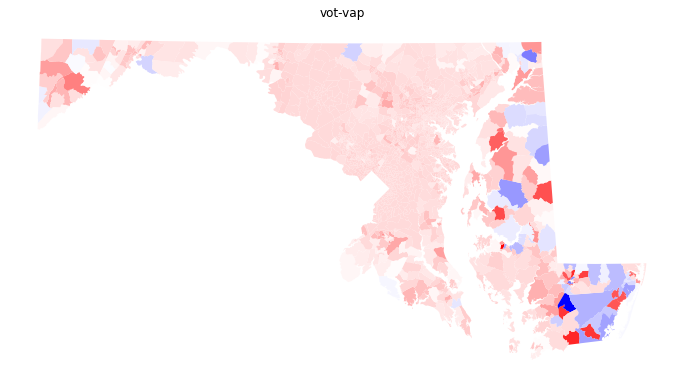

In [175]:
plot_choro(gdf, "vot-vap", cmap="bwr", save=True)

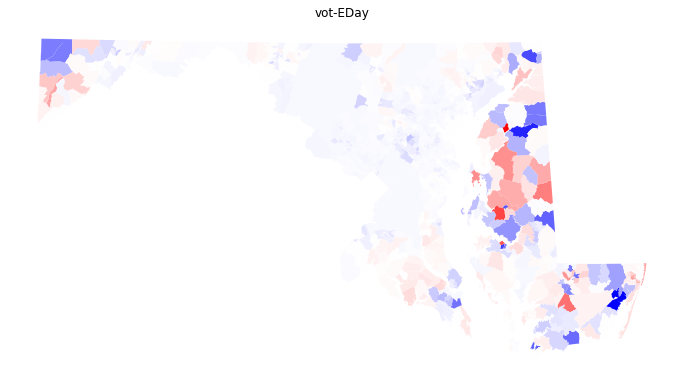

In [176]:
plot_choro(gdf, "vot-EDay", cmap="bwr", save=True)

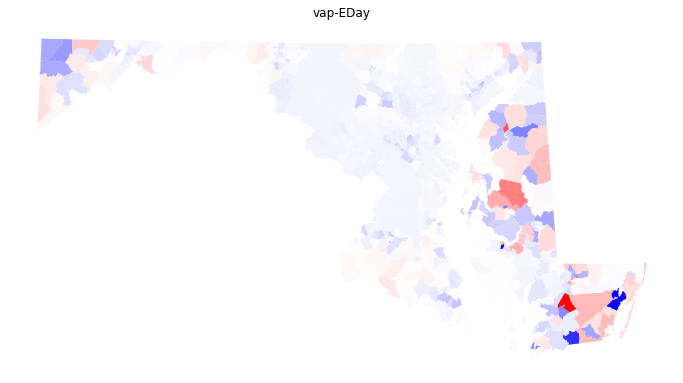

In [177]:
plot_choro(gdf, "vap-EDay", cmap="bwr", save=True)

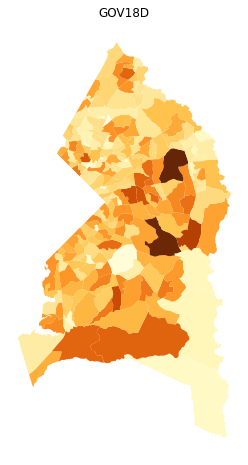

In [51]:
plot_choro(gdf, "GOV18D", county="Prince George's", save=True)

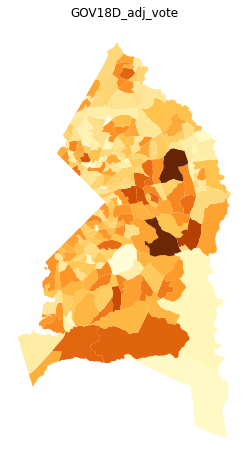

In [52]:
plot_choro(gdf, "GOV18D_adj_vote", county="Prince George's", save=True)

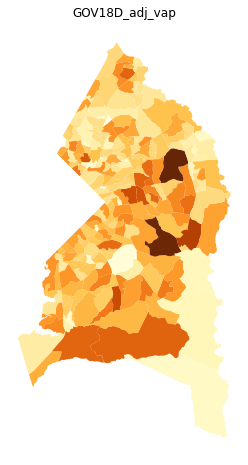

In [53]:
plot_choro(gdf, "GOV18D_adj_vap", county="Prince George's", save=True)